In [1]:
!pip install explainerdashboard==0.3

In [ ]:
!pip install fast_ml

In [3]:
!pip install "dash-bootstrap-components<1"

In [4]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection
from sklearn.preprocessing import scale

from sklearn.metrics import classification_report,confusion_matrix

import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import KFold, cross_val_score, train_test_split

import plotly.graph_objects as go

In [5]:
df=pd.read_csv('/content/Brazilian_dataset_EDA_Clustering.csv') #Read the Csv File

**Feature Extraction**

In [6]:
#converting the type of Invoice Date Field from string to datetime.
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])

In [7]:
df_6m = df[(df.order_purchase_timestamp >= pd.to_datetime('2017-6-1')) & (df.order_purchase_timestamp  < pd.to_datetime('2017-12-1'))].reset_index(drop=True)

In [8]:
df_6m.head()

,Unnamed: 0,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,...,recency,frequency,monetary,f_quartile,r_quartile,m_quartile,RFM_Score,RFM_Score_s,RFM_Level,clusters
0,0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-10 21:25:13,2017-10-18 00:00:00,1,credit_card,...,335.0,2.0,62.23,1.0,2.0,2.0,212.0,5.0,Promising,4.0
1,1,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-18 14:44:43,2017-08-28 00:00:00,1,credit_card,...,383.0,1.0,37.77,1.0,1.0,1.0,111.0,3.0,Require Activation,1.0
2,2,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-07 18:30:01,2017-08-15 00:00:00,1,credit_card,...,396.0,1.0,37.77,1.0,1.0,1.0,111.0,3.0,Require Activation,1.0
3,3,bfc39df4f36c3693ff3b63fcbea9e90a,53904ddbea91e1e92b2b3f1d09a7af86,delivered,2017-10-23 23:26:46,2017-10-25 02:14:11,2017-11-07 18:04:59,2017-11-13 00:00:00,1,boleto,...,314.0,1.0,44.09,1.0,2.0,1.0,211.0,4.0,Needs Attention,1.0
4,4,6ea2f835b4556291ffdc53fa0b3b95e8,c7340080e394356141681bd4c9b8fe31,delivered,2017-11-24 21:27:48,2017-11-25 00:21:09,2017-12-28 18:59:23,2017-12-21 00:00:00,1,credit_card,...,282.0,1.0,356.12,1.0,2.0,4.0,214.0,7.0,Loyal,3.0


In [9]:
#calculate revenue and create a new dataframe for it
df_6m['Revenue'] = df_6m['price'] * df_6m['order_item_id']
orders_user_6m = df_6m.groupby('customer_unique_id')['Revenue'].sum().reset_index()
orders_user_6m.columns = ['customer_unique_id','m6_Revenue']


#plot LTV histogram
# plot_data = [
#     go.Histogram(
#         x=orders_user_6m.query('m6_Revenue < 10000')['m6_Revenue']
#     )
# ]

# plot_layout = go.Layout(
#         title='6m Revenue'
#     )
# fig = go.Figure(data=plot_data, layout=plot_layout)
# fig.show()


In [10]:
df_classification = df[['recency', 'frequency', 'monetary', 'r_quartile', 'f_quartile', 'm_quartile', 'RFM_Score_s', 'clusters', 'customer_unique_id','RFM_Level']]

In [11]:
df_classification = pd.merge(df_classification, orders_user_6m, on='customer_unique_id', how='left')
df_classification = df_classification.fillna(0)

In [12]:
#remove outliers
df_classification = df_classification[df_classification['m6_Revenue']<df_classification['m6_Revenue'].quantile(0.99)]

from sklearn.cluster import KMeans

#creating 3 clusters
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_classification[['m6_Revenue']])
df_classification['LTVCluster'] = kmeans.predict(df_classification[['m6_Revenue']])

In [13]:
df_classification.groupby('LTVCluster')['m6_Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
LTVCluster,,,,,,,,
0,24454.0,1.607902,6.415039,0.0,0.0,0.0,0.0000,37.00
1,1739.0,191.359040,49.634178,132.2,149.9,178.5,219.9900,334.98
2,4962.0,72.915568,25.187369,37.4,52.9,60.0,89.9975,131.90


**Feature Selection**

[Feature Selection Techniques](https://towardsdatascience.com/the-5-feature-selection-algorithms-every-data-scientist-need-to-know-3a6b566efd2)

In [14]:
#create X and y, X will be feature set and y is the label - LTV
X = df_classification.drop(['LTVCluster','m6_Revenue', 'customer_unique_id'],axis=1)
X = pd.get_dummies(X)
y = df_classification['LTVCluster']

**Pearson’s correlation**

In [15]:
num_feats = 8

def cor_selector(X, y,num_feats):
    cor_list = []
    feature_name = X.columns.tolist()
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature

cor_support, cor_feature = cor_selector(X, y,num_feats)
print(str(len(cor_feature)), 'selected features')

8 selected features


In [16]:
print(cor_feature)

["RFM_Level_Can't Loose Them", 'RFM_Level_Champions', 'RFM_Level_Needs Attention', 'RFM_Level_Promising', 'clusters', 'RFM_Score_s', 'recency', 'r_quartile']


**Chi-squared Test**

In [17]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=num_feats)
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()
print(str(len(chi_feature)), 'selected features')
print(chi_feature)

8 selected features
['recency', 'r_quartile', 'clusters', "RFM_Level_Can't Loose Them", 'RFM_Level_Champions', 'RFM_Level_Loyal', 'RFM_Level_Needs Attention', 'RFM_Level_Promising']


**Recursive Feature Elimination**

In [18]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=num_feats, step=10, verbose=5)
rfe_selector.fit(X_norm, y)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')
print(rfe_feature)

Fitting estimator with 16 features.


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


8 selected features
['recency', 'frequency', 'monetary', 'r_quartile', 'm_quartile', 'clusters', 'RFM_Level_Loyal', 'RFM_Level_Needs Attention']


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


**Lasso : SelectFromModel**

In [19]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l2"), max_features=num_feats)
embeded_lr_selector.fit(X_norm, y)

embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = X.loc[:,embeded_lr_support].columns.tolist()
print(str(len(embeded_lr_feature)), 'selected features')

print(embeded_lr_feature)

6 selected features
['recency', 'frequency', 'monetary', 'r_quartile', 'm_quartile', 'clusters']


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


**Tree-based: SelectFromModel**

In [22]:
from sklearn.feature_selection import SelectFromModel
from lightgbm import LGBMClassifier

lgbc=LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
            reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

embeded_lgb_selector = SelectFromModel(lgbc, max_features=num_feats)
embeded_lgb_selector.fit(X, y)

embeded_lgb_support = embeded_lgb_selector.get_support()
embeded_lgb_feature = X.loc[:,embeded_lgb_support].columns.tolist()
print(str(len(embeded_lgb_feature)), 'selected features')

print(embeded_lgb_feature)

3 selected features
['recency', 'monetary', 'RFM_Score_s']


**Using RandomForest**

In [23]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=num_feats)
embeded_rf_selector.fit(X, y)

embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()
print(str(len(embeded_rf_feature)), 'selected features')

print(embeded_rf_feature)

3 selected features
['recency', 'monetary', 'r_quartile']


**Aggregation of all feature selection methods**

In [24]:
feature_name = X.columns
# put all selection together
feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support, 'Chi-2':chi_support, 'RFE':rfe_support, 'Logistics':embeded_lr_support,
                                    'Random Forest':embeded_rf_support, 'LightGBM':embeded_lgb_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)
feature_selection_df.head(num_feats)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:84: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return reduction(axis=axis, out=out, **passkwargs)


,Feature,Pearson,Chi-2,RFE,Logistics,Random Forest,LightGBM,Total
1,recency,True,True,True,True,True,True,6
2,r_quartile,True,True,True,True,True,False,5
3,monetary,False,False,True,True,True,True,4
4,clusters,True,True,True,True,False,False,4
5,RFM_Level_Needs Attention,True,True,True,False,False,False,3
6,m_quartile,False,False,True,True,False,False,2
7,frequency,False,False,True,True,False,False,2
8,RFM_Score_s,True,False,False,False,False,True,2


**Splitting data into training, testing and validation**

In [25]:
features_selected = X[['recency','r_quartile','monetary', 'm_quartile', 'clusters']]

In [26]:
X_train, X_rem, y_train, y_rem = train_test_split(X[['recency','r_quartile','monetary', 'm_quartile', 'clusters']],y, train_size=0.8)
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.1)

In [27]:
print(X_train.shape), print(y_train.shape)
print(X_valid.shape), print(y_valid.shape)
print(X_test.shape), print(y_test.shape)

(24924, 5)
(24924,)
(5607, 5)
(5607,)
(624, 5)
(624,)


(None, None)

**Modeling : MullerLoop**

In [37]:
names = ["Random Forest", "AdaBoost", "MLP Classifier", "Decision Tree"]

In [38]:
classifier = [
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    AdaBoostClassifier(),
    MLPClassifier(alpha=1, max_iter=1000),
    DecisionTreeClassifier(max_depth=5)]

In [39]:
max_score = 0.0
max_class = ''
clf_list = []
# iterate over classifiers
for name, clf in zip(names, classifier):
    clf_model = name + "_model"
    clf_model = clf.fit(X_train, y_train)
    score = 100.0 * clf_model.score(X_test, y_test)
    print('classifier = %s, Score (test, accuracy) = %.2f,' %(name, score))
    clf_list.append(clf_model)

    if score > max_score:
        clf_best = clf
        max_score = score
        max_class = name

print(clf_list)
print(80*'-' )
print('Best --> classifier = %s, Score (test, accuracy) = %.2f' %(max_class, max_score))
#plot the output of the various algorithms

classifier = Random Forest, Score (test, accuracy) = 95.19,
classifier = AdaBoost, Score (test, accuracy) = 96.96,
classifier = MLP Classifier, Score (test, accuracy) = 90.06,
classifier = Decision Tree, Score (test, accuracy) = 96.79,
[RandomForestClassifier(max_depth=5, max_features=1, n_estimators=10), AdaBoostClassifier(), MLPClassifier(alpha=1, max_iter=1000), DecisionTreeClassifier(max_depth=5)]
--------------------------------------------------------------------------------
Best --> classifier = AdaBoost, Score (test, accuracy) = 96.96


**Interactive smote**

In [29]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from time import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from yellowbrick.classifier import ROCAUC

def plot_ROC_curve(model, xtrain, ytrain, xtest, ytest):

    # Creating visualization with the readable labels
    visualizer = ROCAUC(model, encoder={0: 'Mid-level', 
                                        1: 'Low-level', 
                                        2: 'High-level'})                                    
    # Fitting to the training data first then scoring with the test data                                    
    visualizer.fit(xtrain, ytrain)
    visualizer.score(xtest, ytest)
    return visualizer

def muller(X,y):
  names = ["Nearest Neighbors",
          "Decision Tree", "Random Forest", "AdaBoost",
          "Naive Bayes"]
  
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)
  classifiers = [
      KNeighborsClassifier(3),
      DecisionTreeClassifier(),
      RandomForestClassifier(n_estimators=10, max_features=1),
      AdaBoostClassifier(),
      GaussianNB()]
  max_score = 0.0
  max_class = ''
  # iterate over classifiers
  for name, clf in zip(names, classifiers):
      start_time = time()
      clf.fit(X_train, y_train)
      score = 100.0 * clf.score(X_test, y_test)
      print('Classifier = %s, Score (test, accuracy) = %.2f,' %(name, score), 'Training time = %.2f seconds' % (time() - start_time))
      if score > max_score:
          clf_best = clf
          max_score = score
          max_class = name

  print(80*'-' )
  print('Best --> Classifier = %s, Score (test, accuracy) = %.2f' %(max_class, max_score))
  return clf_best,X_test,y_test,X_train,y_train

In [30]:
def on_button_clicked(b):
  fig, ax = plt.subplots(1,2)
  global new_X
  global y
  global checkbox
  only_selected_values=[]
  for x in checkbox:
    if checkbox[x].value==True:
      only_selected_values.append(checkbox[x].description)
  final_X = features_selected.loc[:,only_selected_values]
  oversample = SMOTE()
  resampled_X, resampled_y = oversample.fit_resample(final_X,y)
  original_class_distribution = Counter(resampled_y)
  strategy = {0:original_class_distribution[0]+round((slider1.value/100)*len(resampled_X)), 1:original_class_distribution[1]+round((slider2.value/100)*len(resampled_X)), 2:original_class_distribution[2]+round((slider3.value/100)*len(resampled_X))}
  oversample1 = SMOTE(sampling_strategy=strategy)
  resampled_X1, resampled_y1 = oversample1.fit_resample(resampled_X,resampled_y)
  best_classifier,X_test, y_test,X_train,y_train = muller(resampled_X1,resampled_y1)
  plot_confusion_matrix(best_classifier,X_test,y_test,ax=ax[0])
  plot_ROC_curve(best_classifier,X_train,y_train,X_test,y_test)
  plt.show()

In [31]:
from imblearn.over_sampling import SMOTE 
import ipywidgets as widgets
from IPython.display import display, clear_output
from collections import Counter
slider1 = widgets.IntSlider(min=0, max=100,description='Class 0',step=1)
slider2 = widgets.IntSlider(min=0, max=100,description='Class 1',step=1)
slider3 = widgets.IntSlider(min=0, max=100,description='Class 2',step=1)

print("Select Percentage of data distribution")
display(slider1,slider2,slider3)

Select Percentage of data distribution


IntSlider(value=0, description='Class 0')

IntSlider(value=0, description='Class 1')

IntSlider(value=0, description='Class 2')

In [32]:
checkbox={}
for x in features_selected.columns:
    checkbox[x]=widgets.Checkbox(value=True,description=x)

print("Features selection for analysis")
for x in checkbox:
  display(checkbox[x])

Features selection for analysis


Checkbox(value=True, description='recency')

Checkbox(value=True, description='r_quartile')

Checkbox(value=True, description='monetary')

Checkbox(value=True, description='m_quartile')

Checkbox(value=True, description='clusters')

Button(description='Compute Metrics', style=ButtonStyle())

/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:300: UserWarning: After over-sampling, the number of samples (78008) in class 0 will be larger than the number of samples in the majority class (class #0 -> 24454)
  f"After over-sampling, the number of samples ({n_samples})"
/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:300: UserWarning: After over-sampling, the number of samples (55266) in class 1 will be larger than the number of samples in the majority class (class #0 -> 24454)
  f"After over-sampling, the number of samples ({n_samples})"
/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:300: UserWarning: After over-sampling, the number of samples (86078) in class 2 will be larger than the number of samples in the majority class (class #0 -> 24454)
  f"After over-sampling, the number of samples ({n_samples})"


Classifier = Nearest Neighbors, Score (test, accuracy) = 97.38, Training time = 1.65 seconds
Classifier = Decision Tree, Score (test, accuracy) = 96.75, Training time = 1.00 seconds
Classifier = Random Forest, Score (test, accuracy) = 97.04, Training time = 2.51 seconds
Classifier = AdaBoost, Score (test, accuracy) = 90.41, Training time = 7.12 seconds
Classifier = Naive Bayes, Score (test, accuracy) = 77.00, Training time = 0.05 seconds
--------------------------------------------------------------------------------
Best --> Classifier = Nearest Neighbors, Score (test, accuracy) = 97.38


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"


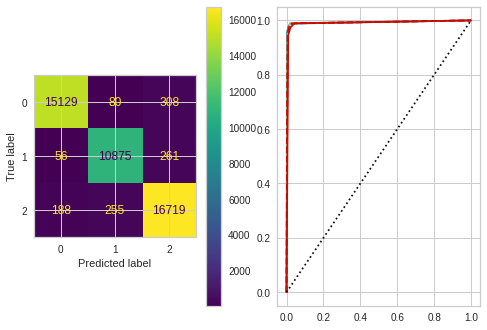

In [34]:
button = widgets.Button(description="Compute Metrics")
button.on_click(on_button_clicked)
display(button)

**Explainer Dashboard**

In [41]:
df_sample = df_classification.sample(1000)
X = df_sample[['recency','r_quartile','monetary', 'm_quartile', 'clusters']]
y = df_sample['LTVCluster']

X_train_sam, X_test_sam, y_train_sam, y_test_sam = train_test_split(X,y, train_size=0.8)

In [42]:
from explainerdashboard import ClassifierExplainer,ExplainerDashboard,ExplainerHub
explainer_clf_1 = ClassifierExplainer(clf_list[0], X_train_sam,y_train_sam)
explainer_clf_2 = ClassifierExplainer(clf_list[1], X_train_sam,y_train_sam, shap='kernel')
explainer_clf_3 = ClassifierExplainer(clf_list[2], X_train_sam,y_train_sam, shap='kernel')
explainer_clf_4 = ClassifierExplainer(clf_list[3], X_train_sam,y_train_sam)

Note: shap=='guess' so guessing for RandomForestClassifier shap='tree'...
Detected RandomForestClassifier model: Changing class type to RandomForestClassifierExplainer...


X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
Using 800 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
X does not have valid feature names, but MLPClassifier was fitted with feature names
Using 800 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Note: model_output=='probability', so assuming that raw shap output of RandomForestClassifier is in probability space...
Generating self.shap_explainer = shap.TreeExplainer(model)
Note: shap values for shap='kernel' normally get calculated against X_background, but paramater X_background=None, so using X instead...
Generating self.shap_explainer = shap.KernelExplainer(model, X, link='identity')
Note: shap values for shap='kernel' normally get calculated against X_background, but paramater X_background=None, so using X instead...
Generating self.shap_explainer = shap.KernelExplainer(model, X, link='identity')
Note: shap=='guess' so guessing for DecisionTreeClassifier shap='tree'...
Note: model_output=='probability', so assuming that raw shap output of DecisionTreeClassifier is in probability space...
Generating self.shap_explainer = shap.TreeExplainer(model)


In [43]:
db1 = ExplainerDashboard(explainer_clf_1, shap_interaction=False, title="Random Forest", name="Random Forest")
db2 = ExplainerDashboard(explainer_clf_2, shap_interaction=False, title="AdaBoost", name="AdaBoost")
db3 = ExplainerDashboard(explainer_clf_3, shap_interaction=False, title="MLP Classifier", name="MLP Classifier")
db4 = ExplainerDashboard(explainer_clf_4, shap_interaction=False, title="Decision Tree", name="Decision Tree")

Building ExplainerDashboard..
Detected google colab environment, setting mode='external'
Generating layout...
Calculating shap values...
Calculating dependencies...
Calculating permutation importances (if slow, try setting n_jobs parameter)...
Calculating predictions...
Calculating pred_percentiles...
Calculating prediction probabilities...
Reminder: you can store the explainer (including calculated dependencies) with explainer.dump('explainer.joblib') and reload with e.g. ClassifierExplainer.from_file('explainer.joblib')
Registering callbacks...
Building ExplainerDashboard..
Detected google colab environment, setting mode='external'
The explainer object has no decision_trees property. so setting decision_trees=False...
Generating layout...
Calculating shap values...


  0%|          | 0/800 [00:00<?, ?it/s]

X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
X does not

Calculating dependencies...
Calculating permutation importances (if slow, try setting n_jobs parameter)...
Calculating predictions...
Calculating pred_percentiles...
Calculating prediction probabilities...
Reminder: you can store the explainer (including calculated dependencies) with explainer.dump('explainer.joblib') and reload with e.g. ClassifierExplainer.from_file('explainer.joblib')
Registering callbacks...
Building ExplainerDashboard..
Detected google colab environment, setting mode='external'
The explainer object has no decision_trees property. so setting decision_trees=False...
Generating layout...
Calculating shap values...


  0%|          | 0/800 [00:00<?, ?it/s]

X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted

Calculating dependencies...
Calculating permutation importances (if slow, try setting n_jobs parameter)...
Calculating predictions...
Calculating pred_percentiles...
Calculating prediction probabilities...
Reminder: you can store the explainer (including calculated dependencies) with explainer.dump('explainer.joblib') and reload with e.g. ClassifierExplainer.from_file('explainer.joblib')
Registering callbacks...
Building ExplainerDashboard..
Detected google colab environment, setting mode='external'
The explainer object has no decision_trees property. so setting decision_trees=False...
Generating layout...
Calculating shap values...
Calculating dependencies...
Calculating permutation importances (if slow, try setting n_jobs parameter)...
Calculating predictions...
Calculating pred_percentiles...
Calculating prediction probabilities...
Reminder: you can store the explainer (including calculated dependencies) with explainer.dump('explainer.joblib') and reload with e.g. ClassifierExplaine

In [44]:
db1.run(port=8050, host = '127.0.0.1')

Dash app running on:


<IPython.core.display.Javascript object>

In [45]:
db2.run(port=8051, host = '127.0.0.1')

Dash app running on:


<IPython.core.display.Javascript object>

In [46]:
db3.run(port=8052, host = '127.0.0.1')

Dash app running on:


<IPython.core.display.Javascript object>

In [47]:
db4.run(port=8053, host = '127.0.0.1')

Dash app running on:


<IPython.core.display.Javascript object>